# 3.6 Predicting house prices: a regression example

The two previous examples were considered classification problems, where the goal
was to predict a single discrete label of an input data point. Another common type of
machine-learning problem is __regression__, which consists of predicting a continuous
value instead of a discrete label: for instance, predicting the temperature tomorrow,
given meteorological data; or predicting the time that a software project will take to
complete, given its specifications.

NOTE: Don’t confuse regression and the algorithm logistic regression. Confusingly,
logistic regression isn’t a regression algorithm—it’s a classification
algorithm.

## 3.6.1 The Boston Housing Price dataset

You’ll attempt to predict the median price of homes in a given Boston suburb in the
mid-1970s, given data points about the suburb at the time, such as the crime rate, the
local property tax rate, and so on. The dataset you’ll use has an interesting difference
from the two previous examples. It has relatively few data points: only 506, split
between 404 training samples and 102 test samples. And each __feature__ in the input data
(for example, the crime rate) has a different scale. For instance, some values are proportions,
which take values between 0 and 1; others take values between 1 and 12, others
between 0 and 100, and so on.

In [1]:
# Loading the Boston housing dataset
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 1s 11us/step


Let’s look at the data:

In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

As you can see, you have 404 training samples and 102 test samples, each with 13
numerical features, such as per capita crime rate, average number of rooms per dwelling,
accessibility to highways, and so on.

The targets are the __median values__ of owner-occupied homes, in thousands of
dollars:

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The prices are typically between 10,000 dollar and 50,000 dollar. If that sounds cheap, remember
that this was the mid-1970s, and these prices aren’t adjusted for inflation.

## 3.6.2 Preparing the data

It would be problematic to feed into a neural network values that all take wildly different
ranges. The network might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult. A widespread best practice
to deal with such data is to do __feature-wise normalization__: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation. This is easily done in Numpy.

In [5]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the __quantities used for normalizing the test data are computed using the
training data__. You __should never use__ in your workflow __any quantity computed on the
test data__, even for something as simple as data normalization.

## 3.6.3 Building your network

Because so few samples are available, you’ll use a very small network with two hidden
layers, each with 64 units. In general, the less training data you have, the worse overfitting
will be, and using a small network is one way to mitigate overfitting.

In [6]:
# Model definition
from keras import models
from keras import layers

def build_model():
    # Because you’ll need to instantiate
    # the same model multiple times, you
    # use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network ends with a single unit and no activation (it will be a linear layer). This is
a typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). Applying an activation function would constrain the range the output
can take; for instance, if you applied a sigmoid activation function to the last layer,
the network could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the network is free to learn to predict values in any range.

Note that you compile the network with the __mse__ loss function—__mean squared error__,
the square of the difference between the predictions and the targets. This is a widely
used loss function for regression problems.

You’re also monitoring a new metric during training: __mean absolute error__ (MAE). It’s
the absolute value of the difference between the predictions and the targets. For
instance, an MAE of 0.5 on this problem would mean your predictions are off by 500 dollar
on average.

## 3.6.4 Validating your approach using K-fold validation

To evaluate your network while you keep adjusting its parameters (such as the number
of epochs used for training), you could split the data into a training set and a validation
set, as you did in the previous examples.But because you have so few data points,
the validation set would end up being very small (for instance, about 100 examples).

To evaluate your network while you keep adjusting its parameters (such as the number
of epochs used for training), you could split the data into a training set and a validation
set, as you did in the previous examples. But because you have so few data points,
the validation set would end up being very small (for instance, about 100 examples).
As a consequence, the validation scores might change a lot depending on which data
points you chose to use for validation and which you chose for training: the validation
scores might have a high __variance__ with regard to the validation split. This would prevent
you from reliably evaluating your model.

The best practice in such situations is to use __K-fold__ cross-validation (see figure below).
It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating
K identical models, and training each one on K – 1 partitions while evaluating on
the remaining partition. The validation score for the model used is then the average of
the K validation scores obtained. In terms of code, this is straightforward.

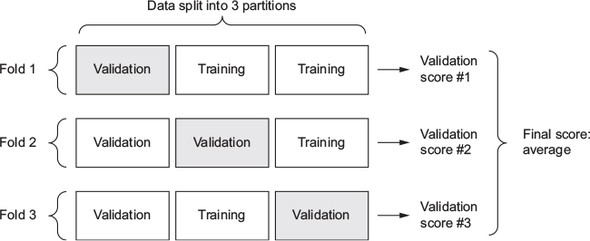

In [7]:
# K-fold validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples : ]], axis=0)
    partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i + 1) * num_val_samples : ]], axis=0)
    
    # Builds the Keras model(already compiled)
    model = build_model()
    
    # Trains the model(in silent mode, verbose = 0)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evaluates the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


Running this with num_epochs = 100 yields the following results:

In [8]:
all_scores

[2.045096540214992, 2.2263333939089636, 3.0003551846683614, 2.3260700679061435]

In [9]:
np.mean(all_scores)

2.399463796674615

The different runs do indeed show rather different validation scores, from 2.6 to 3.2.
The average (3.0) is a much more reliable metric than any single score—that’s the
entire point of K-fold cross-validation. In this case, you’re off by 3,000 dollar on average,
which is significant considering that the prices range from 10,000 dollar to 50,000 dollar.

Let’s try training the network a bit longer: 500 epochs. To keep a record of how
well the model does at each epoch, you’ll modify the training loop to save the perepoch
validation score log.

In [10]:
# Saving the validation logs at each fold
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


You can then compute the average of the per-epoch MAE scores for all folds.

In [11]:
# Building the history of successive mean K-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

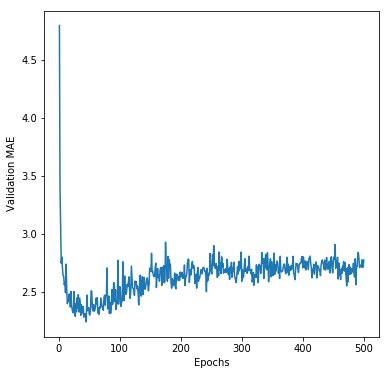

In [22]:
# Plotting validation scores
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

In [23]:
# Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

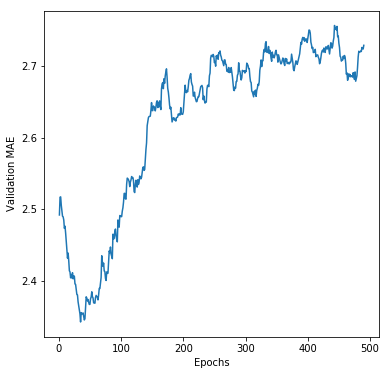

In [24]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.figure(figsize=(6,6))
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs.
Past that point, you start overfitting.

Once you’re finished tuning other parameters of the model (in addition to the
number of epochs, you could also adjust the size of the hidden layers), you can train a
final production model on all of the training data, with the best parameters, and then
look at its performance on the test data.

In [25]:
# Training the final model
model = build_model()
# Trains it on the entirety of the data
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


Here’s the final result:

In [26]:
test_mae_score

2.6821929426754223

You’re still off by about 2,550 dollar.

## 3.6.5  Wrapping up

Here’s what you should take away from this example:
* Regression is done using different loss functions than what we used for classification. Mean squared error ( MSE ) is a loss function commonly used for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error ( MAE ).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
* When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting.